In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [114]:
df = pd.read_csv('../data.csv')
df.pop('rotacao')

# exibe fragmento dos dados
df.head()

,defeito,severidade,fundamental,ax1_1h,ax1_2h,ax1_3h,ax1_4h,ax1_5h,ax1_entr,ax1_kurt,...,tg2_1h,tg2_2h,tg2_3h,tg2_4h,tg2_5h,tg2_entr,tg2_kurt,tg2_phase,tg2_rms,tg2_vel_rms
0,desalinhamento_horizontal,0.5,12.0240,5.763304,2.303724,4.995631,0.883278,1.165081,4.061837,-0.087284,...,4.103196,1.291663,1.938869,1.691083,0.753967,4.263879,-0.560705,4.658191,30.617686,1.514539
1,desalinhamento_horizontal,0.5,13.2264,5.743441,0.738770,5.876419,1.065215,1.850058,4.234764,-0.925310,...,4.263214,2.015758,1.673473,0.789208,0.984763,4.235347,-0.563723,4.207117,20.074389,1.412236
2,desalinhamento_horizontal,0.5,14.2284,6.750044,0.592014,5.932356,1.477220,1.746041,4.248849,-0.825305,...,5.040048,2.353400,1.648283,0.968506,1.023963,4.134431,-0.128050,3.552332,15.136744,1.397344
3,desalinhamento_horizontal,0.5,15.0300,5.604445,2.197267,3.685863,1.483171,1.631654,4.261627,-0.845252,...,4.424791,1.688596,0.911779,0.626697,0.833591,4.096497,-0.172433,13.136227,15.223511,1.365880
4,desalinhamento_horizontal,0.5,16.0320,5.655247,1.595719,4.042729,1.852271,25.253904,4.205469,-0.887882,...,5.118254,1.589453,1.078714,0.791082,1.474005,4.175298,-0.306299,12.905109,18.344380,1.193727


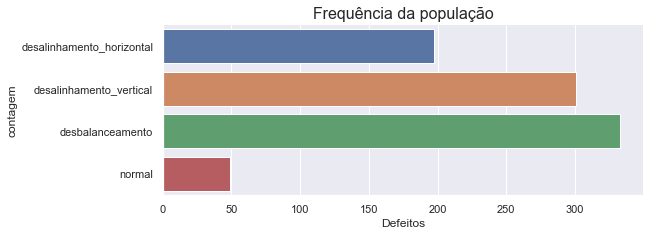

In [115]:
df['defeito'].value_counts()

# plota distribuição da população
sns.catplot(data=df, y='defeito', kind="count", height=3, aspect=3)
plt.title('Frequência da população', fontsize=16)
plt.xlabel('Defeitos')
plt.ylabel('contagem')
plt.show()

In [116]:
output_map = {
    'normal': 0,
    'desbalanceamento': 1,
    'desalinhamento_vertical': 2,
    'desalinhamento_horizontal': 3,
}

# armazena output em um array
labels = np.array(df['defeito'].map(output_map))

In [117]:
# remove a coluna de labels do df original
df = df.drop('defeito', axis = 1)

# salva a ordem das features
feature_list = df.columns

# convertendo df para array
data = np.array(df)

# Modelos

In [118]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GroupKFold, StratifiedKFold

kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

In [119]:
from sklearn.svm import SVC

model = SVC(kernel='linear')
scores = cross_val_score(
    estimator= model,
    X=data, y=labels,
    cv=kfold,
    scoring='accuracy'
)
print(scores.mean(), '+/-', scores.std())

0.990909090909091 +/- 0.007872958216222171


In [120]:
from sklearn.feature_selection import RFECV

min_features_to_select = 1  # Minimum number of features to consider
svc = SVC(kernel='linear')

rfecv = RFECV(estimator=svc, step=1, cv=kfold,
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
rfecv.fit(data, labels)

RFECV(cv=StratifiedKFold(n_splits=8, random_state=42, shuffle=True),
      estimator=SVC(kernel='linear'), scoring='accuracy')

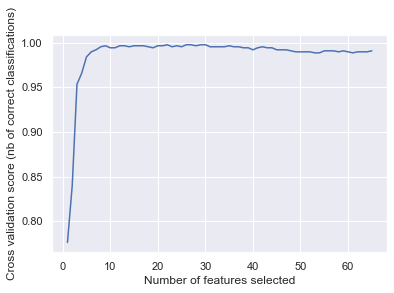

In [121]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [129]:
list(feature_list[rfecv.support_])

['severidade',
 'fundamental',
 'ax1_vel_rms',
 'ax2_1h',
 'ax2_5h',
 'ax2_vel_rms',
 'microfone_kurt',
 'microfone_rms',
 'rad1_entr',
 'rad1_kurt',
 'rad1_rms',
 'rad1_vel_rms',
 'rad2_1h',
 'rad2_4h',
 'rad2_5h',
 'rad2_kurt',
 'tg1_4h',
 'tg1_kurt',
 'tg1_rms',
 'tg2_2h',
 'tg2_4h',
 'tg2_vel_rms']

### Train-Test split

In [131]:
from sklearn.model_selection import train_test_split

# separa os conjuntos de treino e teste com amostragem estratificada,
# logo, mantendo a proporção para cada tipo de defeito
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.25, stratify=output, random_state=42) 

model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

In [132]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_predicted)

array([[12,  0,  0,  0],
       [ 0, 83,  0,  0],
       [ 1,  0, 73,  2],
       [ 1,  0,  0, 48]], dtype=int64)